In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

# Data preprocessing 
## Data preparation:
* Fix NA values
* Parse date-time into pandas dataframe index
* Specified clear names for each columns

In [2]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
temp = pd.read_csv('data_hrly.csv')

In [4]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

pol_avg=dataset['pollution'].mean()
pol_std=dataset['pollution'].std()
low=int(pol_avg-pol_std/2)
high=int(pol_avg+pol_std/2)
dataset['pollution']=dataset['pollution'].apply(lambda x: np.random.choice([x for x in range(low,high)]) if (np.isnan(x)) else x)

In [5]:
dataset['month'] = np.array(temp['month'])
print("** DATA PROCESSING COMPLETED **")
dataset.to_csv('pollution.csv')

** DATA PROCESSING COMPLETED **


# Importing and visualizing the data


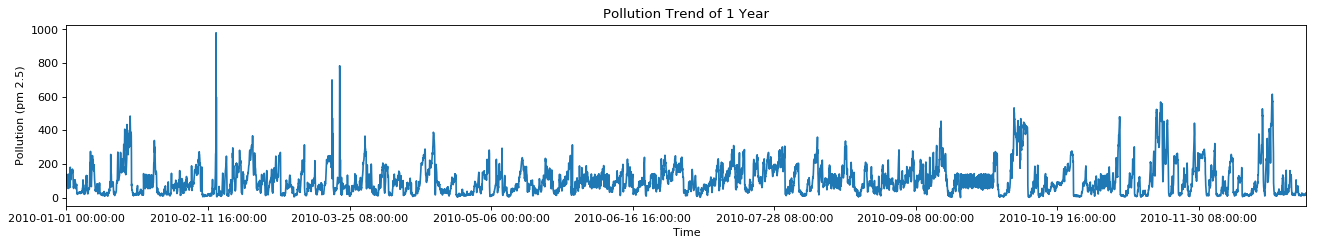

In [6]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#Label Encoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categorical_features=[4])
ohe_month = OneHotEncoder(categorical_features=[10])
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [8]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
dataset= pd.DataFrame(ohe.fit_transform(dataset).toarray()[:,1:])
dataset = ohe_month.fit_transform(dataset).toarray()
dataset = pd.DataFrame(dataset[:,1:])
pollution_data=np.array(dataset.iloc[:,14])
weather_data=np.array(dataset.drop(14,axis=1))
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1))
#Creating the dataset for DNN
weather_data = wea_scaler.fit_transform(weather_data)
print("Shape: ",weather_data.shape)

Shape:  (43824, 20)


/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in vers

# Splitting the data into train and test set

In [9]:
#FOR RNN DATA
cut=24*(35000//24)
training_set_rnn = pollution_data[:cut,:].reshape(-1,24,1)
training_set_dnn = weather_data[:cut,:].reshape(-1,24,20)
test_set_rnn = pollution_data[cut:,:].reshape(-1,24,1)
test_set_dnn = weather_data[cut:,:].reshape(-1,24,20)

tr_rnn=[]
tr_dnn=[]
for day,ddy in zip(training_set_rnn,training_set_dnn):
    mx=day.argmax()
    tr_rnn.append(day[mx])
    tr_dnn.append(ddy.mean(axis=0))

training_set_rnn=np.array(tr_rnn)
training_set_dnn=np.array(tr_dnn)

tst_rnn=[]
tst_dnn=[]
for day,ddy in zip(test_set_rnn,test_set_dnn):
    mx=day.argmax()
    tst_rnn.append(day[mx])
    tst_dnn.append(ddy.mean(axis=0))

test_set_rnn=np.array(tst_rnn)
test_set_dnn=np.array(tst_dnn)

In [10]:
training_set_rnn.shape, training_set_dnn.shape, test_set_rnn.shape, test_set_dnn.shape

((1458, 1), (1458, 20), (368, 1), (368, 20))

In [11]:
PRED_DIST=1

In [12]:
def next_batch(training_data_rnn,training_data_dnn,steps):
    """
    INPUT: Data(For RNN and DNN), Time Steps per batch
    OUTPUT: Input batch for RNN and DNN at 't' and Output data (pollution) at 't+1'
    """
    
    # Randomly initializing the start point
    pred_dist=PRED_DIST
    ts_start = np.random.randint(low = 0, high = len(training_data_rnn)-steps-pred_dist)
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    x_batch_rnn = training_data_rnn[ts_start: ts_start + steps]                  #(steps,1)
    x_batch_dnn = training_data_dnn[ts_start+pred_dist: ts_start+pred_dist+ steps]  #(steps,20)
    x_batch = np.append(x_batch_rnn, x_batch_dnn, axis=1)
    y_out = training_data_rnn[ts_start+pred_dist: ts_start+pred_dist+ steps]  #(steps,1)
    # Values for RNN reshaped to (-1,steps,1)
    #               0 to t                        ,             0 to t       ,1 to t+1 (pred_dist to pred_dist+1)    
    return x_batch.reshape(-1,steps,21), y_out.reshape(steps,1)
    

In [13]:
import os
#Setting up tensorflow on GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from nn_function import *

In [14]:
#Reseting the default global graph
tf.reset_default_graph()

# Creating the neural network

In [15]:
#Declarying the constants
NUMBER_NEU = 128
N_IP = 21
N_OP = 1
STEPS = 60
LR = 0.0001
#For 40k iterations
ITER = 40000
#Output neurons for the LSTM and DNN layers
N_OUT =128

In [16]:
#Placeholders for input batches
x_rnn = tf.placeholder(dtype=tf.float32,shape=(None,None,N_IP))
#Placeholders for output batches
y= tf.placeholder(dtype=tf.float32,shape=(None,N_OP))
#For dropout layers
hold_proba = tf.placeholder(dtype=tf.float32)

In [17]:
#Making the LSTM cell
cell = dropout_wrapper(hold_proba,create_LSTM_cell(NUMBER_NEU))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [18]:
#RNN output
output , states = create_RNN(cell,x_rnn)
#Selecting the final output form the layer
rnn_output = output[-1]
#Connecting the output to a DNN layer
lstm_fc_out = dnn_layer(rnn_output,N_OUT,name="LSTM_op")
# lstm_fc_drop = tf.nn.dropout(lstm_fc_out, hold_proba,name="drop0")
lstm_fc_fin = dnn_layer(lstm_fc_out,1,name="LSTM_fin")

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
#Calculating the final output node with Sigmoid activation
network_op = tf.sigmoid(lstm_fc_fin,name="network_op")

In [20]:
#Creating the MAE loss function
loss = tf.losses.huber_loss(labels=network_op,predictions=y)
#Creating the optimizer and trainer
optim = tf.train.AdamOptimizer(learning_rate=LR)
train = optim.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [21]:
#Creating the varaible initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(ITER):
        x_batch,y_batch = next_batch(training_set_rnn,training_set_dnn,steps=STEPS)
        sess.run(train,feed_dict = {x_rnn:x_batch,y: y_batch , hold_proba:0.8})
        if i % 100 == 0:
            x_test,y_test = next_batch(test_set_rnn,test_set_dnn,steps=7)
            print("At step",i,"\t\tMean Absolute Error (Train): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_batch,y: y_batch , hold_proba:1.0})),"\t\tMean Absolute Error (Test): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_test,y: y_test , hold_proba:1.0})))
    saver.save(sess, "Pollution_model/not_weather")

At step 0 		Mean Absolute Error (Train): 0.06629 		Mean Absolute Error (Test): 0.07169
At step 100 		Mean Absolute Error (Train): 0.01100 		Mean Absolute Error (Test): 0.03440
At step 200 		Mean Absolute Error (Train): 0.01120 		Mean Absolute Error (Test): 0.02628
At step 300 		Mean Absolute Error (Train): 0.00824 		Mean Absolute Error (Test): 0.02129
At step 400 		Mean Absolute Error (Train): 0.01183 		Mean Absolute Error (Test): 0.02086
At step 500 		Mean Absolute Error (Train): 0.00845 		Mean Absolute Error (Test): 0.01729
At step 600 		Mean Absolute Error (Train): 0.00487 		Mean Absolute Error (Test): 0.00953
At step 700 		Mean Absolute Error (Train): 0.00967 		Mean Absolute Error (Test): 0.01393
At step 800 		Mean Absolute Error (Train): 0.00309 		Mean Absolute Error (Test): 0.01087
At step 900 		Mean Absolute Error (Train): 0.00428 		Mean Absolute Error (Test): 0.00674
At step 1000 		Mean Absolute Error (Train): 0.00663 		Mean Absolute Error (Test): 0.00769
At step 1100 		Mean Ab

At step 9200 		Mean Absolute Error (Train): 0.00257 		Mean Absolute Error (Test): 0.00225
At step 9300 		Mean Absolute Error (Train): 0.00221 		Mean Absolute Error (Test): 0.01345
At step 9400 		Mean Absolute Error (Train): 0.00268 		Mean Absolute Error (Test): 0.00133
At step 9500 		Mean Absolute Error (Train): 0.00533 		Mean Absolute Error (Test): 0.00214
At step 9600 		Mean Absolute Error (Train): 0.00217 		Mean Absolute Error (Test): 0.00179
At step 9700 		Mean Absolute Error (Train): 0.00117 		Mean Absolute Error (Test): 0.00132
At step 9800 		Mean Absolute Error (Train): 0.00153 		Mean Absolute Error (Test): 0.00142
At step 9900 		Mean Absolute Error (Train): 0.00129 		Mean Absolute Error (Test): 0.00216
At step 10000 		Mean Absolute Error (Train): 0.00127 		Mean Absolute Error (Test): 0.00249
At step 10100 		Mean Absolute Error (Train): 0.00177 		Mean Absolute Error (Test): 0.00047
At step 10200 		Mean Absolute Error (Train): 0.00331 		Mean Absolute Error (Test): 0.00176
At step

At step 18300 		Mean Absolute Error (Train): 0.00202 		Mean Absolute Error (Test): 0.00140
At step 18400 		Mean Absolute Error (Train): 0.00168 		Mean Absolute Error (Test): 0.00473
At step 18500 		Mean Absolute Error (Train): 0.00560 		Mean Absolute Error (Test): 0.00220
At step 18600 		Mean Absolute Error (Train): 0.00098 		Mean Absolute Error (Test): 0.00210
At step 18700 		Mean Absolute Error (Train): 0.00097 		Mean Absolute Error (Test): 0.00614
At step 18800 		Mean Absolute Error (Train): 0.00179 		Mean Absolute Error (Test): 0.00583
At step 18900 		Mean Absolute Error (Train): 0.00246 		Mean Absolute Error (Test): 0.00129
At step 19000 		Mean Absolute Error (Train): 0.00522 		Mean Absolute Error (Test): 0.00084
At step 19100 		Mean Absolute Error (Train): 0.00604 		Mean Absolute Error (Test): 0.00365
At step 19200 		Mean Absolute Error (Train): 0.00204 		Mean Absolute Error (Test): 0.00223
At step 19300 		Mean Absolute Error (Train): 0.00122 		Mean Absolute Error (Test): 0.00085

At step 27400 		Mean Absolute Error (Train): 0.00255 		Mean Absolute Error (Test): 0.01445
At step 27500 		Mean Absolute Error (Train): 0.00115 		Mean Absolute Error (Test): 0.00225
At step 27600 		Mean Absolute Error (Train): 0.00163 		Mean Absolute Error (Test): 0.00161
At step 27700 		Mean Absolute Error (Train): 0.00157 		Mean Absolute Error (Test): 0.00035
At step 27800 		Mean Absolute Error (Train): 0.00097 		Mean Absolute Error (Test): 0.00416
At step 27900 		Mean Absolute Error (Train): 0.00088 		Mean Absolute Error (Test): 0.00214
At step 28000 		Mean Absolute Error (Train): 0.00185 		Mean Absolute Error (Test): 0.00190
At step 28100 		Mean Absolute Error (Train): 0.00130 		Mean Absolute Error (Test): 0.00275
At step 28200 		Mean Absolute Error (Train): 0.00147 		Mean Absolute Error (Test): 0.00693
At step 28300 		Mean Absolute Error (Train): 0.00146 		Mean Absolute Error (Test): 0.01378
At step 28400 		Mean Absolute Error (Train): 0.00133 		Mean Absolute Error (Test): 0.00747

At step 36500 		Mean Absolute Error (Train): 0.00187 		Mean Absolute Error (Test): 0.00080
At step 36600 		Mean Absolute Error (Train): 0.00163 		Mean Absolute Error (Test): 0.00229
At step 36700 		Mean Absolute Error (Train): 0.00105 		Mean Absolute Error (Test): 0.00243
At step 36800 		Mean Absolute Error (Train): 0.00111 		Mean Absolute Error (Test): 0.00218
At step 36900 		Mean Absolute Error (Train): 0.00073 		Mean Absolute Error (Test): 0.00383
At step 37000 		Mean Absolute Error (Train): 0.00079 		Mean Absolute Error (Test): 0.00138
At step 37100 		Mean Absolute Error (Train): 0.00084 		Mean Absolute Error (Test): 0.00108
At step 37200 		Mean Absolute Error (Train): 0.00115 		Mean Absolute Error (Test): 0.00603
At step 37300 		Mean Absolute Error (Train): 0.00126 		Mean Absolute Error (Test): 0.00148
At step 37400 		Mean Absolute Error (Train): 0.00450 		Mean Absolute Error (Test): 0.01461
At step 37500 		Mean Absolute Error (Train): 0.00183 		Mean Absolute Error (Test): 0.00096

# Visualizing and testing the model 

In [24]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [25]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, "Pollution_model/not_weather")
    #Preparing batches
    x_rnn_batch,y_batch = next_batch(test_set_rnn,test_set_dnn,steps=200)
    #Predicting the output
    output = sess.run(network_op, feed_dict={x_rnn:x_rnn_batch, hold_proba:1.0})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Pollution_model/not_weather


In [26]:
#Inverse scaling the predicted and actual values
y_inversed = pol_scaler.inverse_transform(y_batch).reshape(-1,1)
pred_inversed = pol_scaler.inverse_transform(output).reshape(-1,1)
dataframe = np.append(y_inversed,pred_inversed,1)

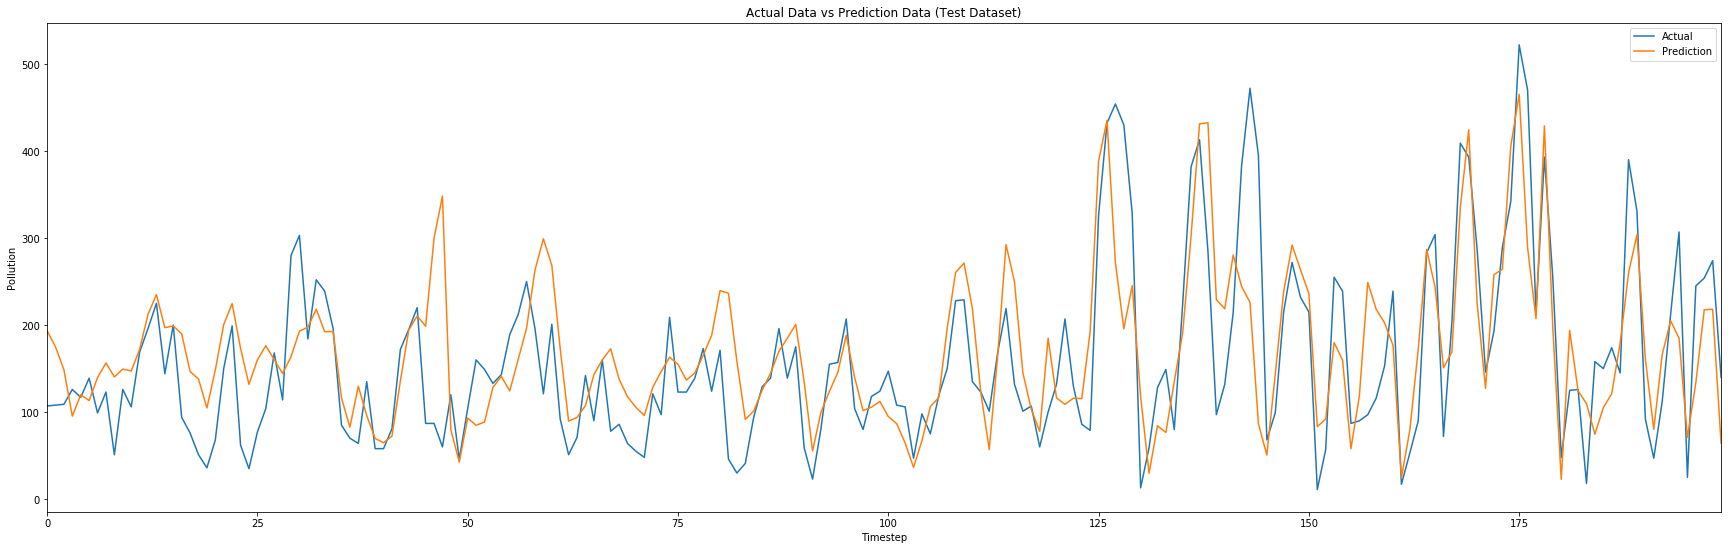

Mean Absolute Error (Test)	=	 55.132337198257446
Root Mean Squared Error (Test)	=	 74.92889764525678
Per cent Error (Test)	=	 10.561750421122117


In [27]:
##Creating the dataframe
df = pd.DataFrame(dataframe,columns=['Actual','Prediction'])
#Plotting the graph
df.plot(figsize=(30,9))
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
#Calculating MAE and RMSE error
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
score_mse = mean_squared_error(y_true,y_pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)
print("Per cent Error (Test)\t=\t",score_mae*100/df['Actual'].max())

In [28]:
#Converting dataset to spreadsheet
df.to_csv('prediction.csv', index=False)

# Predicting Future data

In [29]:
forecast=41
seed=60

In [30]:
with tf.Session() as sess:
    
    # Restoring the model
    saver.restore(sess, "Pollution_model/not_weather")

    #Creating the Seed of 1 Week's data
    train_seed_rnn = list(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
    train_seed_dnn = list(training_set_dnn[-seed-PRED_DIST:-PRED_DIST])
    test_ind = 0
    #Predicting the next week's data
    for iteration in range(forecast):
        rnn_batch = np.array(train_seed_rnn[-forecast:]).reshape(forecast, 1)
        dnn_batch = np.array(train_seed_dnn[-forecast:]).reshape(-1,20)
        x_batch = np.append(rnn_batch, dnn_batch, axis=1).reshape(-1,forecast,21)
        y_pred = sess.run(network_op, feed_dict={x_rnn:x_batch, hold_proba:1.0})
        #print("\nPrediction: ",y_pred[0, -1])
        train_seed_rnn.append(y_pred[-1])
        #print("Feed_data: ",test_set_dnn[test_ind])
        train_seed_dnn.append(test_set_dnn[test_ind])
        test_ind+=1

INFO:tensorflow:Restoring parameters from Pollution_model/not_weather


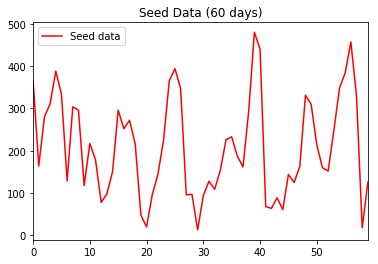

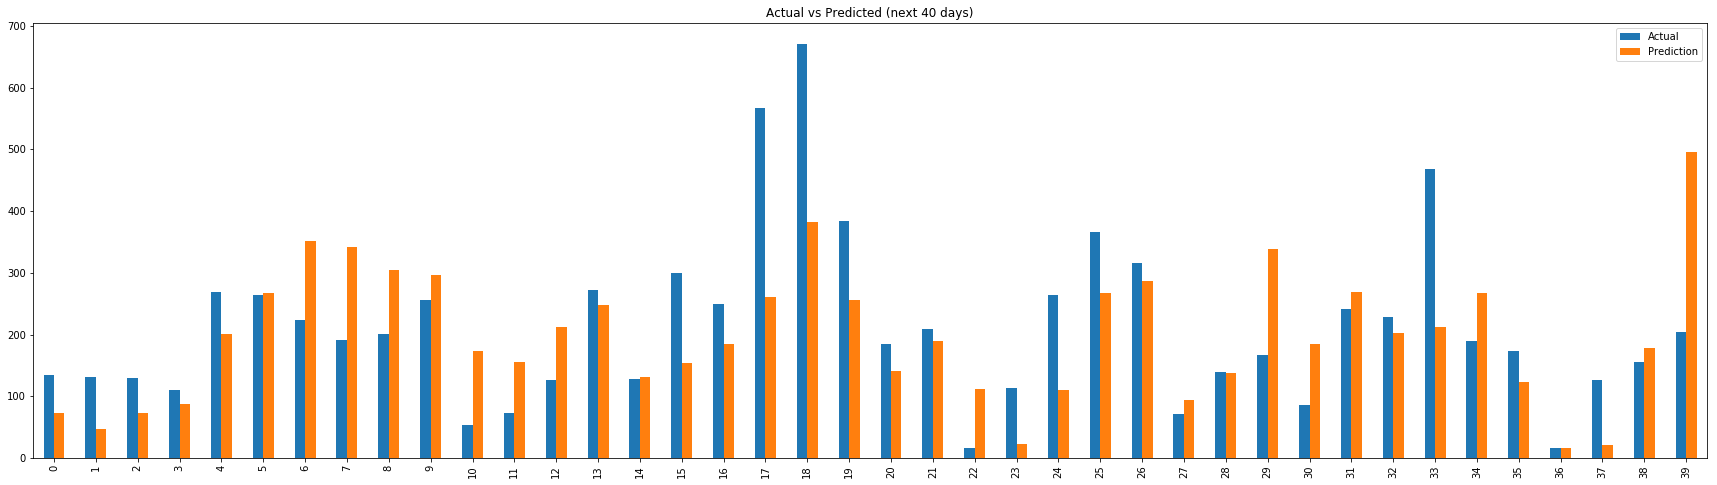

91.22250118255616
Error ratio (Test):	13.60 %


In [31]:
#Inverse scaling the value
seed_data = pol_scaler.inverse_transform(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
prediction_data = pol_scaler.inverse_transform(np.array(train_seed_rnn[-forecast:]))
actual_data =  pol_scaler.inverse_transform(test_set_rnn[:forecast])
pd.DataFrame(list(seed_data[-seed:]),columns=['Seed data']).plot(c='Red')
# plt.ylim((0,350))
plt.title("Seed Data ({} days)".format(seed))
plt.show()
df = pd.DataFrame({'Actual':actual_data[:-1].reshape(1,-1)[0], 'Prediction' :prediction_data[1:].reshape(1,-1)[0]})
df.plot.bar(figsize=(30,8))
# plt.ylim((0,350))
plt.title("Actual vs Predicted (next {} days)".format(forecast-1))
plt.show()
y_pred = df['Prediction'].values
y_true = df['Actual'].values
score_mae = mean_absolute_error(y_true,y_pred)
print(score_mae)
print("Error ratio (Test):\t%1.2f"%((score_mae/df['Actual'].max())*100),"%")

In [32]:
from IPython.display import clear_output
from time import sleep

INFO:tensorflow:Restoring parameters from Pollution_model/not_weather


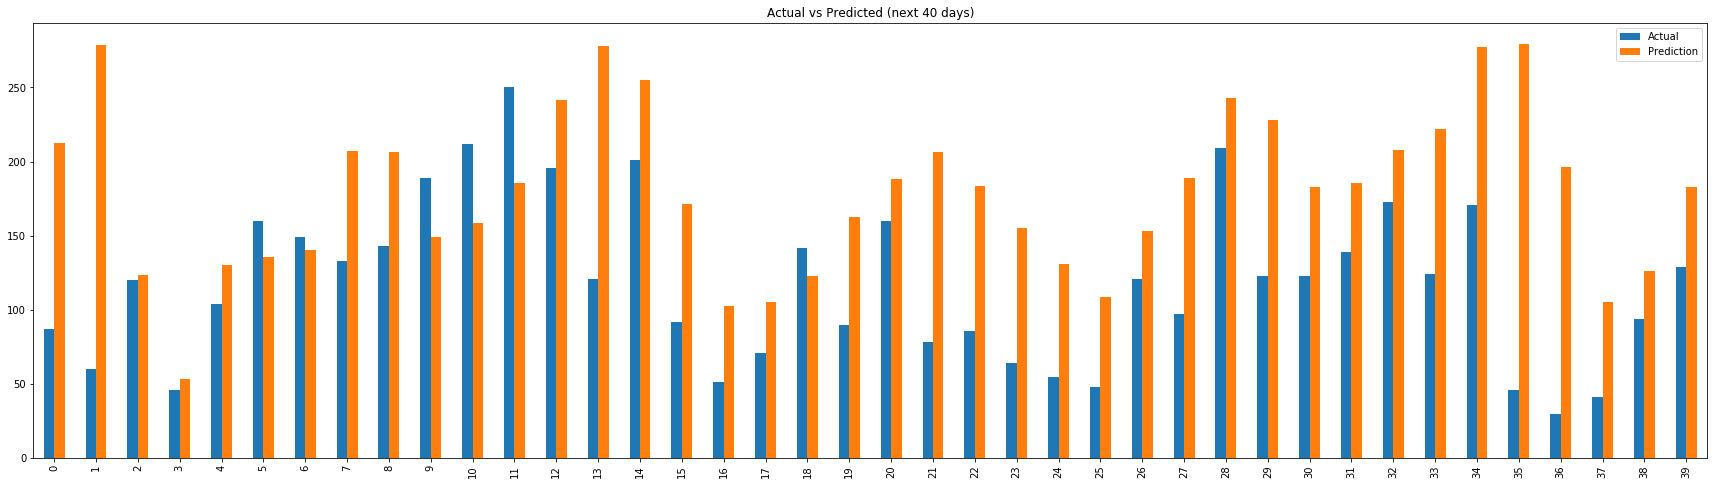

KeyboardInterrupt: 

In [36]:
while True:
    forecast=41
    seed=61
    #FOR RNN DATA
    cut=24*(np.random.choice(range(35000,42850))//24)
#     print("CUT:",cut)
    training_set_rnn = pollution_data[:cut,:].reshape(-1,24,1)
    training_set_dnn = weather_data[:cut,:].reshape(-1,24,20)
    test_set_rnn = pollution_data[cut:,:].reshape(-1,24,1)
    test_set_dnn = weather_data[cut:,:].reshape(-1,24,20)

    tr_rnn=[]
    tr_dnn=[]
    for day,ddy in zip(training_set_rnn,training_set_dnn):
        mx=day.argmax()
        tr_rnn.append(day[mx])
        tr_dnn.append(ddy.mean(axis=0))

    training_set_rnn=np.array(tr_rnn)
    training_set_dnn=np.array(tr_dnn)

    tst_rnn=[]
    tst_dnn=[]
    for day,ddy in zip(test_set_rnn,test_set_dnn):
        mx=day.argmax()
        tst_rnn.append(day[mx])
        tst_dnn.append(ddy.mean(axis=0))

    test_set_rnn=np.array(tst_rnn)
    test_set_dnn=np.array(tst_dnn)

    with tf.Session() as sess:

        # Restoring the model
        saver.restore(sess, "Pollution_model/not_weather")

        #Creating the Seed of 1 Week's data
        train_seed_rnn = list(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
        train_seed_dnn = list(training_set_dnn[-seed-PRED_DIST:-PRED_DIST])
        test_ind = 0
        #Predicting the next week's data
        for iteration in range(forecast):
            rnn_batch = np.array(train_seed_rnn[-forecast:]).reshape(forecast, 1)
            dnn_batch = np.array(train_seed_dnn[-forecast:]).reshape(-1,20)
            x_batch = np.append(rnn_batch, dnn_batch, axis=1).reshape(-1,forecast,21)
            y_pred = sess.run(network_op, feed_dict={x_rnn:x_batch, hold_proba:1.0})
            #print("\nPrediction: ",y_pred[0, -1])
            train_seed_rnn.append(y_pred[-1])
            #print("Feed_data: ",test_set_dnn[test_ind])
            train_seed_dnn.append(test_set_dnn[test_ind])
            test_ind+=1

    #Inverse scaling the value
    seed_data = pol_scaler.inverse_transform(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
    prediction_data = pol_scaler.inverse_transform(np.array(train_seed_rnn[-forecast:]))
    actual_data =  pol_scaler.inverse_transform(test_set_rnn[:forecast])
#     pd.DataFrame(list(seed_data[-seed:]),columns=['Seed data']).plot(c='Red')
#     # plt.ylim((0,350))
#     plt.title("Seed Data ({} days)".format(seed))
#     plt.show()
    df = pd.DataFrame({'Actual':actual_data[:-1].reshape(1,-1)[0], 'Prediction' :prediction_data[1:].reshape(1,-1)[0]})
    df.plot.bar(figsize=(30,8))
#     df.plot(figsize=(30,8))
    # plt.ylim((0,350))
    plt.title("Actual vs Predicted (next {} days)".format(forecast-1))
    plt.show()
    y_pred = df['Prediction'].values
    y_true = df['Actual'].values
    score_mae = mean_absolute_error(y_true,y_pred)
#     print("Mean absolute error:",score_mae)
#     print("Error ratio (Test):\t%1.2f"%((score_mae/df['Actual'].max())*100),"%")
    input()
    clear_output(wait=True)

INFO:tensorflow:Restoring parameters from Pollution_model/not_weather


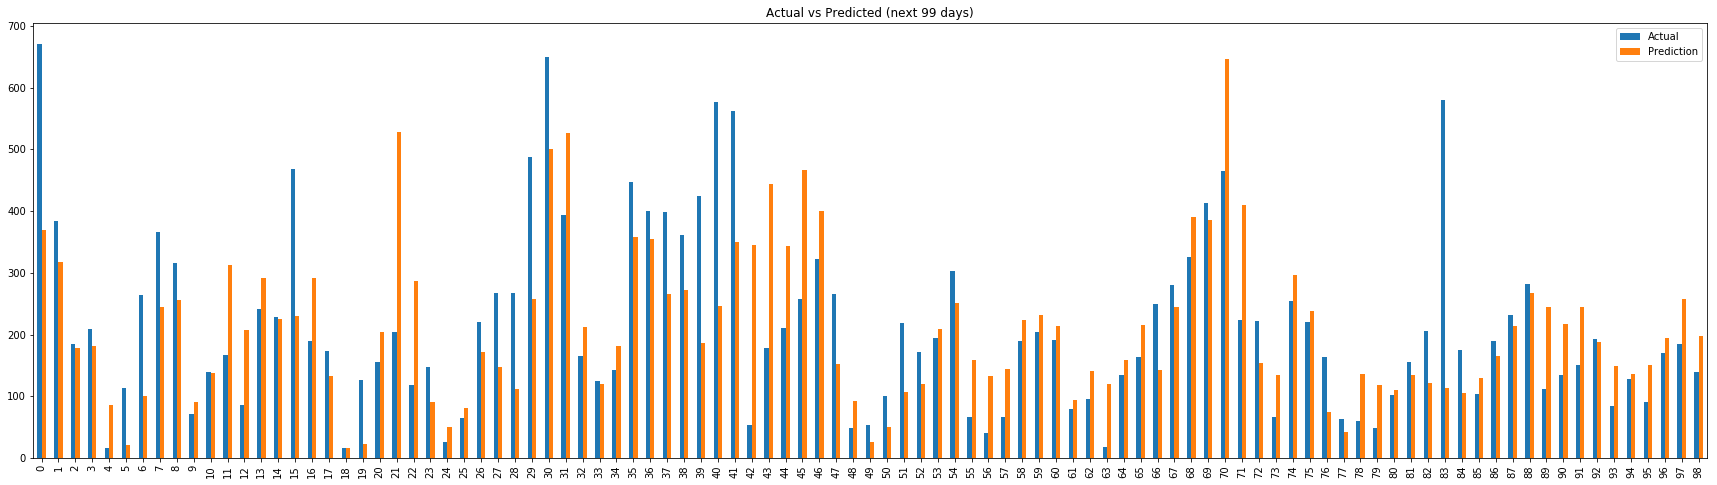

KeyboardInterrupt: 

In [40]:
while True:
    forecast=100
    seed=101
    #FOR RNN DATA
    cut=24*(np.random.choice(range(35000,42850))//24)
#     print("CUT:",cut)
    training_set_rnn = pollution_data[:cut,:].reshape(-1,24,1)
    training_set_dnn = weather_data[:cut,:].reshape(-1,24,20)
    test_set_rnn = pollution_data[cut:,:].reshape(-1,24,1)
    test_set_dnn = weather_data[cut:,:].reshape(-1,24,20)

    tr_rnn=[]
    tr_dnn=[]
    for day,ddy in zip(training_set_rnn,training_set_dnn):
        mx=day.argmax()
        tr_rnn.append(day[mx])
        tr_dnn.append(ddy.mean(axis=0))

    training_set_rnn=np.array(tr_rnn)
    training_set_dnn=np.array(tr_dnn)

    tst_rnn=[]
    tst_dnn=[]
    for day,ddy in zip(test_set_rnn,test_set_dnn):
        mx=day.argmax()
        tst_rnn.append(day[mx])
        tst_dnn.append(ddy.mean(axis=0))

    test_set_rnn=np.array(tst_rnn)
    test_set_dnn=np.array(tst_dnn)

    with tf.Session() as sess:

        # Restoring the model
        saver.restore(sess, "Pollution_model/not_weather")

        #Creating the Seed of 1 Week's data
        train_seed_rnn = list(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
        train_seed_dnn = list(training_set_dnn[-seed-PRED_DIST:-PRED_DIST])
        test_ind = 0
        #Predicting the next week's data
        for iteration in range(forecast):
            rnn_batch = np.array(train_seed_rnn[-forecast:]).reshape(forecast, 1)
            dnn_batch = np.array(train_seed_dnn[-forecast:]).reshape(-1,20)
            x_batch = np.append(rnn_batch, dnn_batch, axis=1).reshape(-1,forecast,21)
            y_pred = sess.run(network_op, feed_dict={x_rnn:x_batch, hold_proba:1.0})
            #print("\nPrediction: ",y_pred[0, -1])
            train_seed_rnn.append(y_pred[-1])
            #print("Feed_data: ",test_set_dnn[test_ind])
            train_seed_dnn.append(test_set_dnn[test_ind])
            test_ind+=1

    #Inverse scaling the value
    seed_data = pol_scaler.inverse_transform(training_set_rnn[-seed-PRED_DIST:-PRED_DIST])
    prediction_data = pol_scaler.inverse_transform(np.array(train_seed_rnn[-forecast:]))
    actual_data =  pol_scaler.inverse_transform(test_set_rnn[:forecast])
#     pd.DataFrame(list(seed_data[-seed:]),columns=['Seed data']).plot(c='Red')
#     # plt.ylim((0,350))
#     plt.title("Seed Data ({} days)".format(seed))
#     plt.show()
    df = pd.DataFrame({'Actual':actual_data[:-1].reshape(1,-1)[0], 'Prediction' :prediction_data[1:].reshape(1,-1)[0]})
    df.plot.bar(figsize=(30,8))
#     df.plot(figsize=(30,8))
    # plt.ylim((0,350))
    plt.title("Actual vs Predicted (next {} days)".format(forecast-1))
    plt.show()
    y_pred = df['Prediction'].values
    y_true = df['Actual'].values
    score_mae = mean_absolute_error(y_true,y_pred)
#     print("Mean absolute error:",score_mae)
#     print("Error ratio (Test):\t%1.2f"%((score_mae/df['Actual'].max())*100),"%")
    input()
    clear_output(wait=True)